# Introduction

# Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt

#Call API
shark_req = requests.get('http://api.fish.wa.gov.au/webapi/v1/RawData')
#convert to dataframe
shark_df = pd.DataFrame(data=shark_req.json())

print(shark_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14919 entries, 0 to 14918
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RawDataId             14919 non-null  int64  
 1   ObjectId              14919 non-null  object 
 2   Distance              11417 non-null  object 
 3   DistanceUnit          11326 non-null  object 
 4   InteractionValue      14919 non-null  object 
 5   InteractionId         14919 non-null  object 
 6   TownProximity         11704 non-null  object 
 7   LocationValue         14919 non-null  object 
 8   SightingNumbervalue   10127 non-null  object 
 9   ReportDateTime        676 non-null    object 
 10  SightingDateTime      14919 non-null  object 
 11  SightingSizeValue     11404 non-null  object 
 12  SightingSpeciesValue  14919 non-null  object 
 13  OwnerValue            14918 non-null  object 
 14  LocationDetail        10731 non-null  object 
 15  LocationX          

Looking at this overview we can see there are some columns with missing values which will need to be explored. The majority of the columns are also object type and some will need to be converted to a different type. Lets first explore which columns will be relevant to us for this analysis, so we dont waste time cleaning columns tht arent required

Here is the documentation for what each column is for:
http://api.fish.wa.gov.au/getattachment/webapi/JSON-API-Data-v1/RawDataEndpoint/RawDataDataset.pdf.aspx?lang=en-AU

I am not interested in what time the sightings were reported, so i will drop this column<br>
As I am only interested in sightings I do not need to know the location detail and will drop this column<br>
Because the location coordinates are given I am not interested in the location value and this will be dropped

In [2]:
shark_df = shark_df.drop(['LocationValue', 'ReportDateTime','LocationDetail', 'TownProximity', 'SightingSizeValue'], axis=1)

We will start by looking at the 'SightingDateTime'column.

In [3]:
#check the format of the SightingDateTime column
shark_df.head()

,RawDataId,ObjectId,Distance,DistanceUnit,InteractionValue,InteractionId,SightingNumbervalue,SightingDateTime,SightingSpeciesValue,OwnerValue,LocationX,LocationY
0,61342,SD1905200354,600,m offshore,caught & released,3,,2020-05-19T03:54:00,tiger,SMART drumline trial,114.98100,-33.90910
1,61340,WA36315TSE,60,m offshore,sighted,1,,2020-05-17T12:15:43,unknown sp.,Public report,115.04000,-34.20470
2,61341,WA89835TSE,,,sighted,1,,2020-05-17T10:30:43,whale carcass,Public report,115.47500,-34.37940
3,61338,2346,None,None,Detected,4,None,2020-05-16T05:48:00,white,Fisheries Advise,115.74312,-31.99596
4,61337,2345,None,None,Detected,4,None,2020-05-16T05:26:00,white,Fisheries Advise,115.74408,-31.98765


We can see that the column comes in a datetime format however it is currently a string.<br>
Lets convert the column to a DateTime format so it can be easily used.<br>
For analysis it will be useful to be able to group sightings by year, month, and week so i will add columns for these


In [4]:
#Convert to DateTime format
shark_df['SightingDateTime'] = pd.to_datetime(shark_df['SightingDateTime'])
#Column for Year
shark_df['year'] = shark_df['SightingDateTime'].dt.year
shark_df['month'] = shark_df['SightingDateTime'].dt.month
shark_df['week'] = shark_df['SightingDateTime'].dt.week
shark_df['day'] = shark_df['SightingDateTime'].dt.dayofyear

#convert isoweek to normal week
#make map then apply map
map_week = ((shark_df['month'] == 1) & (shark_df['week'] ==53))
shark_df['week'] = np.where(map_week, 1, shark_df['week'])

map_week = ((shark_df['month'] == 12) & (shark_df['week'] == 53))
shark_df['week'] = np.where(map_week, 52, shark_df['week'])

map_week = ((shark_df['month'] == 12) & (shark_df['week'] == 1))
shark_df['week'] = np.where(map_week, 52, shark_df['week'])

Because we are interested in where sharks are sighted we need to make the 'Distance' column uniform. It currently has a digit thats size is determined by the 'DistanceUnit' column, lets see what values are in this columns:

In [5]:
print(shark_df['DistanceUnit'].value_counts(dropna = False))
print(shark_df['Distance'].value_counts(dropna = False))


NULL           6230
m offshore     4418
NaN            3593
km offshore     395
                262
m                20
km                1
Name: DistanceUnit, dtype: int64
NULL     6321
NaN      3502
50        749
100       543
20        462
         ... 
280         1
3.5         1
15000       1
4.6         1
0.5         1
Name: Distance, Length: 104, dtype: int64


There are multiple columns that indicate Null values, lets condense these down.
We also need to convert the Distance column to a numeric value as it is currently an object.

In [6]:
# Convert all blank or Null values to NaN
#DistanceUnit
shark_df['DistanceUnit'] = shark_df['DistanceUnit'].replace('NULL', np.NaN)
shark_df['DistanceUnit'] = shark_df['DistanceUnit'].replace('', np.NaN)
#Distance
shark_df['Distance'] = shark_df['Distance'].replace('NULL', np.NaN)
shark_df['Distance'] = shark_df['Distance'].replace('',np.NaN)

#convert Distance to float
shark_df['Distance'] = shark_df['Distance'].astype(float)

shark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14919 entries, 0 to 14918
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   RawDataId             14919 non-null  int64         
 1   ObjectId              14919 non-null  object        
 2   Distance              4834 non-null   float64       
 3   DistanceUnit          4834 non-null   object        
 4   InteractionValue      14919 non-null  object        
 5   InteractionId         14919 non-null  object        
 6   SightingNumbervalue   10127 non-null  object        
 7   SightingDateTime      14919 non-null  datetime64[ns]
 8   SightingSpeciesValue  14919 non-null  object        
 9   OwnerValue            14918 non-null  object        
 10  LocationX             14919 non-null  float64       
 11  LocationY             14919 non-null  float64       
 12  year                  14919 non-null  int64         
 13  month           

There are 2 main units of measure, Meters and Kilometers.<br>
Lets convert all the values to Meters, once this is done the DistanceUnit column is no longer required so will be dropped.

In [7]:
#create Boolean map for meters column
map_Du = ((shark_df['DistanceUnit'] == 'km offshore') | (shark_df['DistanceUnit'] =='km'))

#create meters column by multiplying the Distance column by 100 if 'km' in DistanceUnit
shark_df['distance_meters'] = np.where(map_Du, shark_df['Distance']*1000, shark_df['Distance'])

#check all is correct
print(shark_df[['DistanceUnit', 'Distance', 'distance_meters']].head(10))

#drop uneeded columns
shark_df.drop(['DistanceUnit', 'Distance'], axis = 1)

  DistanceUnit  Distance  distance_meters
0   m offshore     600.0            600.0
1   m offshore      60.0             60.0
2          NaN       NaN              NaN
3         None       NaN              NaN
4         None       NaN              NaN
5         None       NaN              NaN
6         None       NaN              NaN
7         None       NaN              NaN
8   m offshore     100.0            100.0
9   m offshore     150.0            150.0


,RawDataId,ObjectId,InteractionValue,InteractionId,SightingNumbervalue,SightingDateTime,SightingSpeciesValue,OwnerValue,LocationX,LocationY,year,month,week,day,distance_meters
0,61342,SD1905200354,caught & released,3,,2020-05-19 03:54:00,tiger,SMART drumline trial,114.98100,-33.90910,2020,5,21,140,600.0
1,61340,WA36315TSE,sighted,1,,2020-05-17 12:15:43,unknown sp.,Public report,115.04000,-34.20470,2020,5,20,138,60.0
2,61341,WA89835TSE,sighted,1,,2020-05-17 10:30:43,whale carcass,Public report,115.47500,-34.37940,2020,5,20,138,NaN
3,61338,2346,Detected,4,None,2020-05-16 05:48:00,white,Fisheries Advise,115.74312,-31.99596,2020,5,20,137,NaN
4,61337,2345,Detected,4,None,2020-05-16 05:26:00,white,Fisheries Advise,115.74408,-31.98765,2020,5,20,137,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14914,54674,WA00004TSE,Sighted,1,1,2014-10-14 03:40:00,white,Public report,115.04110,-33.54306,2014,10,42,287,10.0
14915,54675,WA00003TSE,Sighted,1,1,2014-10-14 02:08:00,unknown sp.,Public report,115.02817,-33.63339,2014,10,42,287,NaN
14916,54676,WA00002TSE,Sighted,1,1,2014-10-13 03:55:00,white,Public report,115.10530,-33.60111,2014,10,42,286,NaN
14917,46307,1035,Detected,4,NULL,2014-10-13 02:28:00,tiger,Fisheries Advise,115.64283,-32.14411,2014,10,42,286,NaN


What to do with missing values?
options: 
-nothing
-get shoreline data and calculate
-drop column

## Sighting Number
The  SightingNumbervalue is missing data, I will assume that the reason data is missing is because it was a single shark so will replace all missing/null values with 1.<br>
I will make all rows uniform. The columns will be updated to the numeric format of the number shown


In [8]:
#see what values are in column
vs = shark_df.SightingNumbervalue.value_counts(dropna = False)
vs

NULL         6230
NaN          4792
             2934
1             404
2  x          296
school of      94
3 x            90
4 x            46
5 x            16
6 x            12
2               2
5               1
2x              1
4               1
Name: SightingNumbervalue, dtype: int64

In [9]:
#save values to a list 
cols = list(pd.DataFrame([vs]).columns)
#create replacement list
rep = [1,1,1,1,2,3, 3,4,5,6,2,2,5,4]

#replace values to uniform format
shark_df['SightingNumbervalue'] = shark_df['SightingNumbervalue'].replace(cols, rep)

#Check values
shark_df['SightingNumbervalue'].value_counts(dropna = False)


1    14360
2      299
3      184
4       47
5       17
6       12
Name: SightingNumbervalue, dtype: int64

## Interaction Types

From the dictionary provided by the data owners we can see that there should only be types of detection
- 1 = sighted
- 2= tagged and released
- 3 = caught and released
- 4 = detected

Lets look at the InteractionValue and InteractionID columns to check if this is what we have


In [10]:
print(shark_df['InteractionId'].value_counts(dropna=False).sort_index())
print('\n\n',shark_df['InteractionValue'].value_counts(dropna=False))


1    5211
2      88
3     168
4    9433
5       2
6      17
Name: InteractionId, dtype: int64


 Detected                        9432
sighted                         5153
caught & released                168
tagged & released                 91
Sighted                           44
caught, relocated & released      17
detected                          10
tagged, relocated & released       2
tagged and released                1
sighted                            1
Name: InteractionValue, dtype: int64


We can see from the above values that the InteractionID list contains 5 and 6 which are not mentioned in the dictionary.<br>
We can also see that the InteractionValue contains multiple formats of the same value and also has extra relocated values.

I will condense the Interaction Value column down into a uniform list and as i do not care for relocation i will change them to match the corresponding values. Once this is done I can use this column as the source of all interactions and drop InteractionId as it will provide the same information.

In [11]:
#Replace values in column
shark_df['InteractionValue'] = shark_df['InteractionValue'].replace({'Sighted':'sighted', 
                                                                    'caught, relocated & released':'caught & released',
                                                                    'tagged, relocated & released':'tagged & released',
                                                                    'tagged and released':'tagged & released',
                                                                    'Detected':'detected'})


#check column is as expected
print(shark_df['InteractionValue'].value_counts(dropna = False))

detected             9442
sighted              5197
caught & released     185
tagged & released      94
sighted                 1
Name: InteractionValue, dtype: int64


We have successfully merged all the rows into a cohesive format, I will now drop the InteractionId column as it shows the same data and is no longer required

## Shark Species

Lets look at the SightingSpeciesvalue to determin if this column is ready to use

In [12]:
shark_df['SightingSpeciesValue'].value_counts(dropna = False)

bronze whaler                 5299
tiger                         3650
unknown sp.                   3513
white                         1753
hammerhead                     255
whale carcass                  139
whaler                         109
bull                            62
sonar object                    45
mako                            34
other                           23
grey nurse                       9
dusky                            8
blue                             4
detection event - possible       4
whale carcass                    4
                                 3
blacktip                         3
white                            1
Whale Carcass                    1
Name: SightingSpeciesValue, dtype: int64

Looking at the list of values we can see that there are duplicate values as well as missing values. I will change the following values to make the list uniform:

- whaler to bronze whaler
- other to unknown sp.
- detection evemt to unknown sp.
- sonar object to unknow sp.
- change duplicates to uniform format

In [13]:
shark_df['SightingSpeciesValue'] = shark_df['SightingSpeciesValue'].replace({
    
                                        'whaler':'bronze whaler',
                                        'other':'unknown sp.',
                                        'detection event - possible':'unknown sp.',
                                        'sonar object':'unknown sp.',
                                        'white ':'white',
                                        'whale carcass ': 'whale carcass',
                                        'Whale Carcass':'whale carcass',
                                        '':'unknown sp.'})

shark_df['SightingSpeciesValue'].value_counts(dropna = False)

bronze whaler    5408
tiger            3650
unknown sp.      3588
white            1754
hammerhead        255
whale carcass     144
bull               62
mako               34
grey nurse          9
dusky               8
blue                4
blacktip            3
Name: SightingSpeciesValue, dtype: int64

The list is now in a uniform format.

I will drop the whale carcass rows from the dataframe as i do not need these for some of my analysis. I will save a seperate dataframe that includes all of the information.

In [ ]:
#save dataframe
shark_whale_df = shark_df.copy()

#drop a rows with 'whale carcass'
shark_df = shark_df[shark_df['SightingSpeciesValue'] != 'whale carcass']

## Add Region Column

In [ ]:
def get_region(df):
    x = df['LocationY']
    y = df['LocationX']
    
    if x > - 19.91:
        return 'Kimberly'
    elif (x > -22.28) & (y > 114.5):
        return 'Pilbara'
    elif (x > -27.85):
        return 'Gascoyne'
    elif (x > -27.1 ):
        return 'Mid West'
    elif (x > -30.15):
        return 'Wheatbelt'
    elif (x > -32.95):
        return 'Perth/Peel'
    elif ( y < 116.75):
        return 'South West'
    elif (y < 119.5):
        return 'Great Southern'
    
    else :return 'Esperance'
    
shark_df['region'] = shark_df.apply(get_region, axis = 1)

shark_df['region'].value_counts(dropna = False)


In [ ]:
#Create column of unique ids
shark_df['new_id'] = shark_df['ObjectId']+shark_df['SightingSpeciesValue']

#Mark first unique values as 'Unique'
unique_id = shark_df.duplicated(subset = 'new_id',keep = 'first')
shark_df['unique'] = np.where(unique_id, 1, 'Unique')

# Analysis
Now all our data is in a usable format we can start analysing the data.<br>

First lets look at how the number of sightings changesover the course of a year

In [17]:
import calendar
x = shark_df['SightingNumbervalue'].sum(axis=0)
print(x)
#Add variable for months and total
months = calendar.month_name[1:13]
months.append('Total')

#Create pivot of sightings by month
sightings_piv = pd.pivot_table(shark_df, index='month',
                       columns = 'InteractionValue',
                       values = 'SightingNumbervalue',
                       aggfunc = np.sum )
sightings_piv = sightings_piv.reset_index()

#add a total column
sightings_piv['total'] = sightings_piv.iloc[:,1:].sum(axis=1)

#add total row
total_row = sightings_piv.sum(axis = 0)
sightings_piv = sightings_piv.append(total_row,ignore_index=True)
sightings_piv['month'] = months

#add average column
sightings_piv['average'] = sightings_piv['total']/len(shark_df['year'].unique())

#view pivot
sightings_piv


15698


InteractionValue,month,caught & released,detected,sighted,sighted,tagged & released,total,average
0,January,24.0,1019.0,1112.0,NaN,2.0,2157.0,308.142857
1,February,20.0,576.0,526.0,NaN,6.0,1128.0,161.142857
2,March,37.0,855.0,647.0,NaN,3.0,1542.0,220.285714
3,April,25.0,200.0,917.0,1.0,1.0,1144.0,163.428571
4,May,15.0,211.0,167.0,NaN,3.0,396.0,56.571429
5,June,5.0,246.0,91.0,NaN,2.0,344.0,49.142857
6,July,5.0,229.0,112.0,NaN,4.0,350.0,50.000000
7,August,2.0,274.0,122.0,NaN,12.0,410.0,58.571429
8,September,4.0,780.0,208.0,NaN,14.0,1006.0,143.714286
9,October,7.0,2136.0,315.0,NaN,16.0,2474.0,353.428571


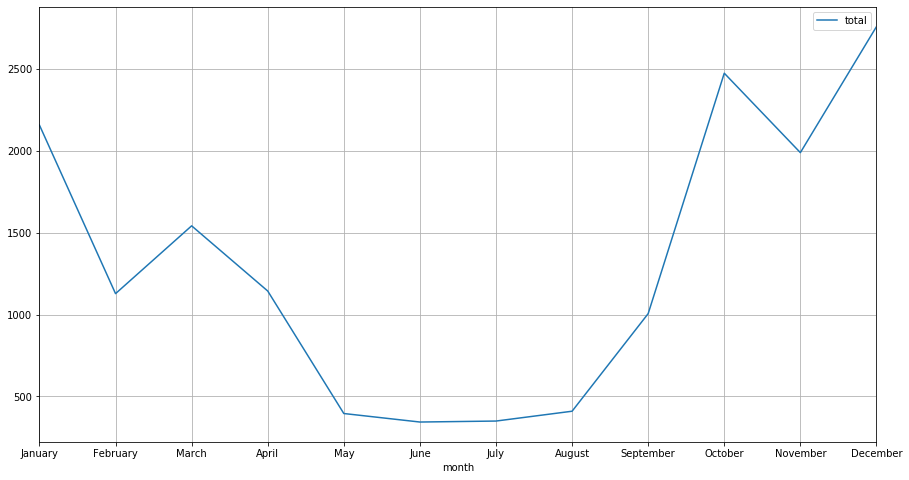

In [18]:
#Generate line graph of total sightings per month
sightings_piv.iloc[:12].plot.line(y='total', 
                        x='month',
                        grid = True,
                        figsize = [15,8],
                        xlim = [0,11],
                           )
#set xticks
plt.xticks(np.arange(12), calendar.month_name[1:13])
plt.show()

As we can see from the abpve graph, sightings rise in the summer months and drop in the winter. This is due to the fact that sharks are migratory animals and and migrate in the winter. A second reason for this is that in winter less people are near/on the sea and as such are not there to see the sharks. <br>

Lets look at only sharks that have been detected via radio transmitter. This will give a better view as this is an automatic process and people are not needed.

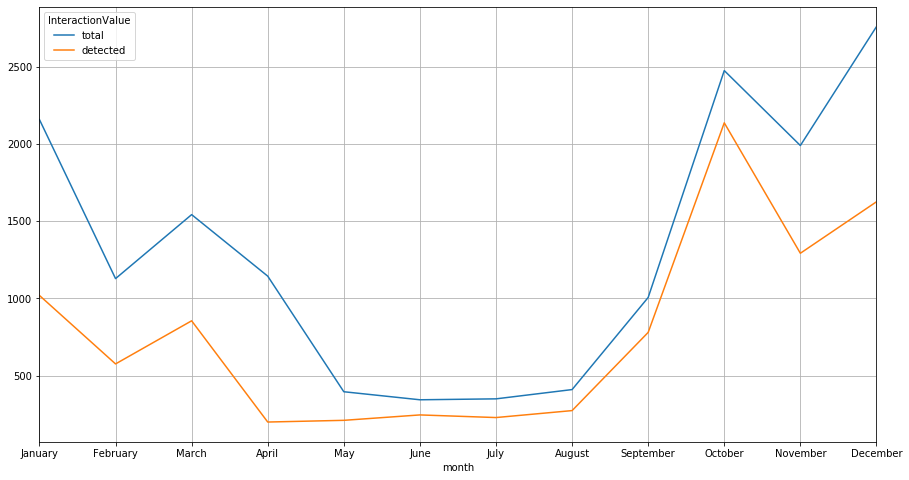

In [19]:
sightings_piv.iloc[0:12].plot.line(y=['total','detected'], 
                        x='month',
                        grid = True,
                        figsize = [15,8],
                        xlim = [0,11]
               )
plt.xticks(np.arange(12), calendar.month_name[1:13])
plt.show()

Comparing these two graphs we can see there is still a huge spike in the summer months (Notably October) and a drop off in winter.

There is a significant difference between the number of total sightings and the number of detections for December and January, this is likely because of the summer holidays and an influx of people heading to the water for their time off, resulting in more eyes to spot sharks.

## Species

Next lets look at which species of shark are most commonly sighted.

I will count by the unique ID to minimise the amount of times a single shark is counted

In [20]:
#Create DF of unique sharks
unique_sharks = shark_df.drop_duplicates(subset = 'ObjectId',keep = 'first')

#View number of unique sharks
print(unique_sharks['SightingSpeciesValue'].value_counts())#.plot(kind = 'bar')
print(unique_sharks['SightingSpeciesValue'].value_counts().sum())


unknown sp.      3583
white             782
tiger             572
bronze whaler     483
hammerhead        254
bull               62
mako               34
grey nurse          9
dusky               8
blue                4
blacktip            3
Name: SightingSpeciesValue, dtype: int64
5794


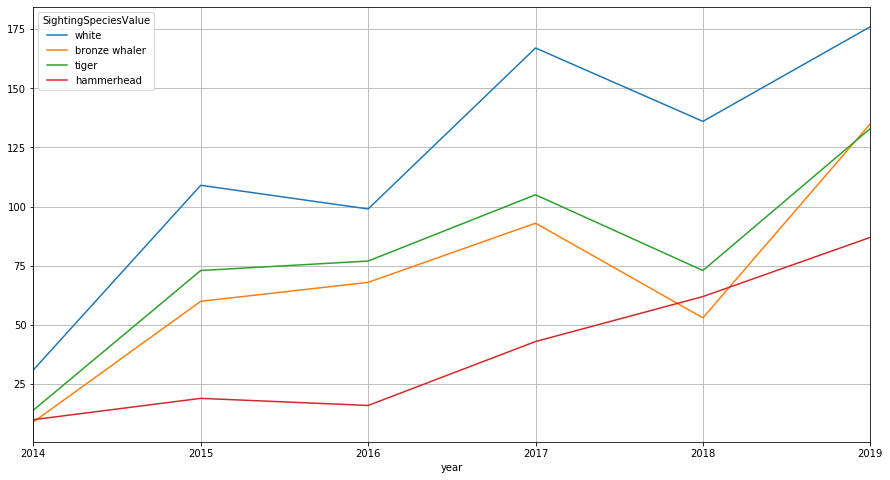

In [21]:
spe_piv = pd.pivot_table(unique_sharks, index='year',
                       columns = 'SightingSpeciesValue',
                       values = 'SightingNumbervalue',
                       aggfunc = 'count' )
spe_piv = spe_piv.reset_index()
spe_piv.plot.line(figsize = [15,8],
                  grid = True,
                  y = ['white', 'bronze whaler', 'tiger', 'hammerhead'], 
                  x = 'year', 
                  xlim = [2014,2019])

We can see that the majority of sharks are unknown, this is likely because it is hard to ID a shark that is partially submerged and the average person doesnt have the knowledge to Id them.

Great whites are the most common sighting of ID'd sharks. This could be due to the fact that they are the most recognisable shark species so are easier to ID.


## Location

Lets look at where sighting are most common

In [22]:
from mpl_toolkits.basemap import Basemap
lats = list(shark_df['LocationY'])
lons= list(shark_df['LocationX'])

D:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-1577036.7807297038,-3670689.739519276,-1481484.565593657,-3534295.38889157&bboxSR=3577&imageSR=3577&size=1500,2141&dpi=96&format=png32&transparent=true&f=image


HTTPError: HTTP Error 502: Bad Gateway

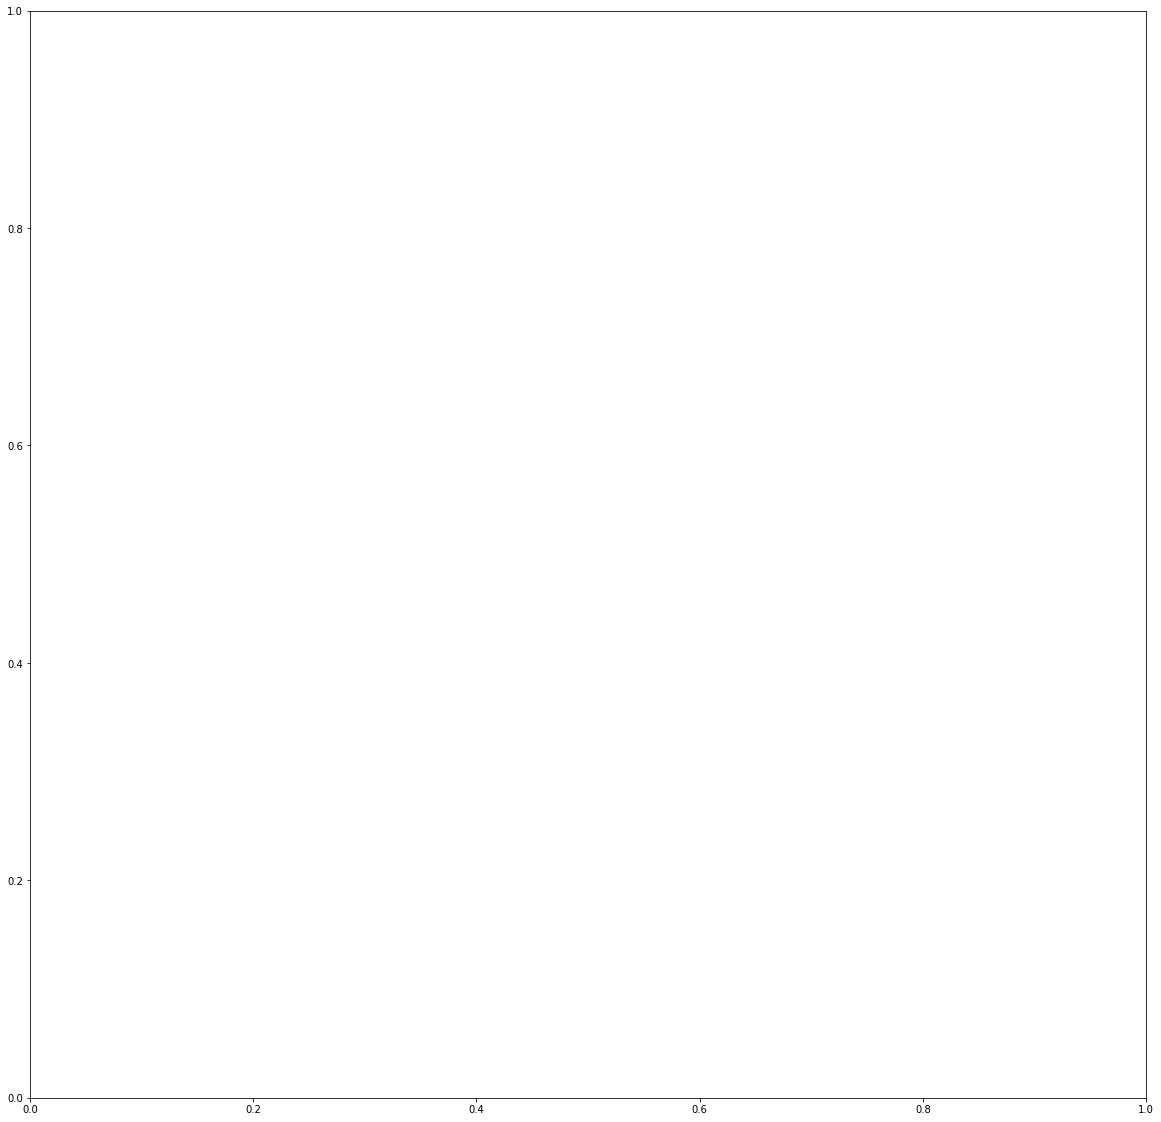

In [23]:
fig = plt.gcf()
fig.set_size_inches(20, 20)

m = Basemap(epsg=3577, \
            llcrnrlat=-32.7, urcrnrlat=-31.6, \
            llcrnrlon=115, urcrnrlon=116.2, \
            lat_ts=20, \
            resolution='h')

m.arcgisimage(service='NatGeo_World_Map', xpixels = 1500, verbose= True)
x, y = m(lons, lats)  # transform coordinates
plt.scatter(x, y, color = 'red', marker='D',s=1) 

plt.show()

In [ ]:
corr = shark_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
shark_df.to_csv("shark.csv")